## resources:

- [cell augment](https://github.com/selimsef/dsb2018_topcoders/blob/7a87c07e1fb8e090186a3914a1443469f5107962/albu/src/augmentations/transforms.py)

- [imgaug](http://imgaug.readthedocs.io/en/latest/)

In [1]:
cd /home/xupeng/projects/synapse

/home/xupeng/projects/synapse


In [2]:
import os, sys
sys.path.append('bin/synapse_pytorch/')
#sys.path.append('bin/dsb2018/')

In [3]:
from imgaug import augmenters as iaa
%pylab inline
import numpy as np
import h5py

Populating the interactive namespace from numpy and matplotlib


In [71]:
from libs.composition import Compose, OneOf, GrayscaleOrColor
import libs.funtional as F

In [7]:
with h5py.File('data/cremi/images/im_A_v2_200.h5','r') as f:
    rawA = f['main'][:]
with h5py.File('data/cremi/gt-syn/syn_A_v2_200.h5','r') as f:
    cleftsA = f['main'][:]
testdatraw = rawA[40:43]
testdatseg = cleftsA[40:43]

- random zoom, rotate, flip
- contrast and brightness
- heavy geometric transform:  Elastic Transform, Perspective Transform, Piecewise Affine transforms, Pincushion Distortion
- contrast limited adaptive histogram equalization (CLAHE) ，Sharpen，Emboss
- Gaussian noise
- Blur、Median Blur、Motion Blur
- 随机色相、饱和度、明度（HSV）变换
- 通道重排——由于数据的天然性，这一点非常重要？
- 图像上细胞核的复制。这样就创造了大量重叠的细胞核，似乎有助于网络更好地学到重叠细胞核的边界？

#### details to notice:
- some transformation only appliued to images (images only)
- flip, transpose (x, y, z, xy transpose has been implemented)
- random rotate (90,180,270 seems only 90 is new)

In [10]:
class BasicTransform:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, **kwargs):
        if random.random() < self.prob:
            params = self.get_params()
            return {k: self.apply(a, **params) if k in self.targets else a for k, a in kwargs.items()}
        return kwargs

    def apply(self, img, **params):
        raise NotImplementedError

    def get_params(self):
        return {}

    @property
    def targets(self):
        # you must specify targets in subclass
        # for example: ('image', 'mask')
        #              ('image', 'boxes')
        raise NotImplementedError

class BasicIAATransform(BasicTransform):
    def __init__(self, prob=0.5):
        super().__init__(prob)
        self.processor = iaa.Noop()
        self.deterministic_processor = iaa.Noop()

    def __call__(self, **kwargs):
        self.deterministic_processor = self.processor.to_deterministic()
        return super().__call__(**kwargs)

    def apply(self, img, **params):
        return self.deterministic_processor.augment_image(img)

class DualTransform(BasicTransform):
    """
    transfrom for segmentation task
    """

    @property
    def targets(self):
        return 'image', 'mask'

class ImageOnlyTransform(BasicTransform):
    """
    transforms applied to image only
    """

    @property
    def targets(self):
        return 'image'

F.vflip(rawA[0]).shape

#### new augment
- contrarotate 90 degree
- center_crop  used to crop center

##### contrarotate 90 degrees

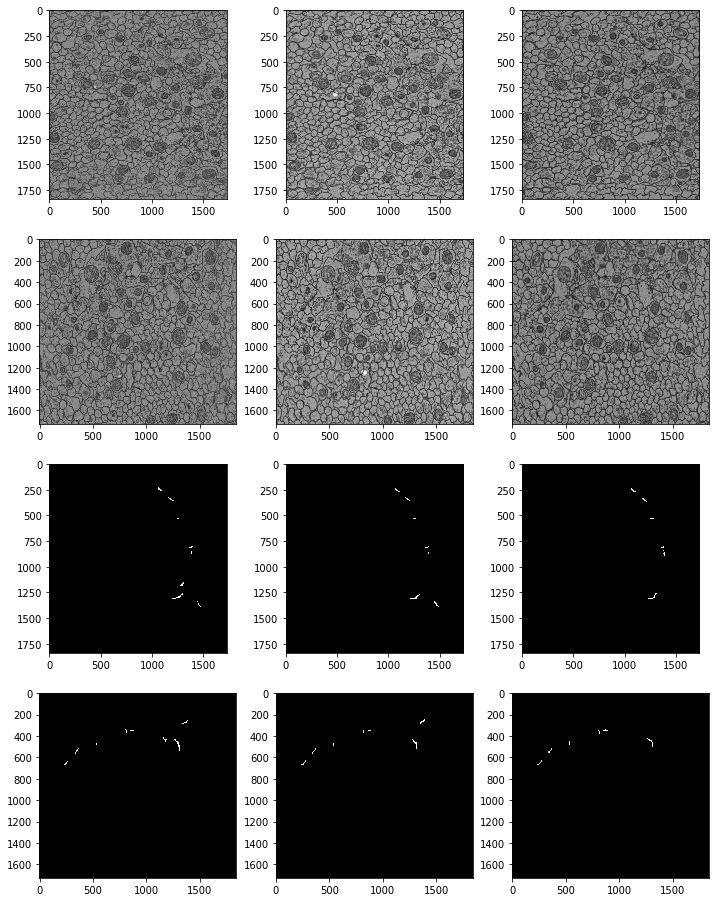

In [60]:
fig,ax=plt.subplots(4,3,figsize=(12,16))
for i in range(4):
    for j in range(3):
        if i ==0:
            ax[i,j].imshow(testdatraw[j],cmap='gray')
        elif i ==1:
            ax[i,j].imshow(F.rot90(testdatraw[j],1),cmap='gray')
        elif i ==2:
            ax[i,j].imshow(testdatseg[j],cmap='gray')
        elif i ==3:
            ax[i,j].imshow(F.rot90(testdatseg[j],1),cmap='gray')

##### shift_scale_rotate
not appropriate for images with many details?

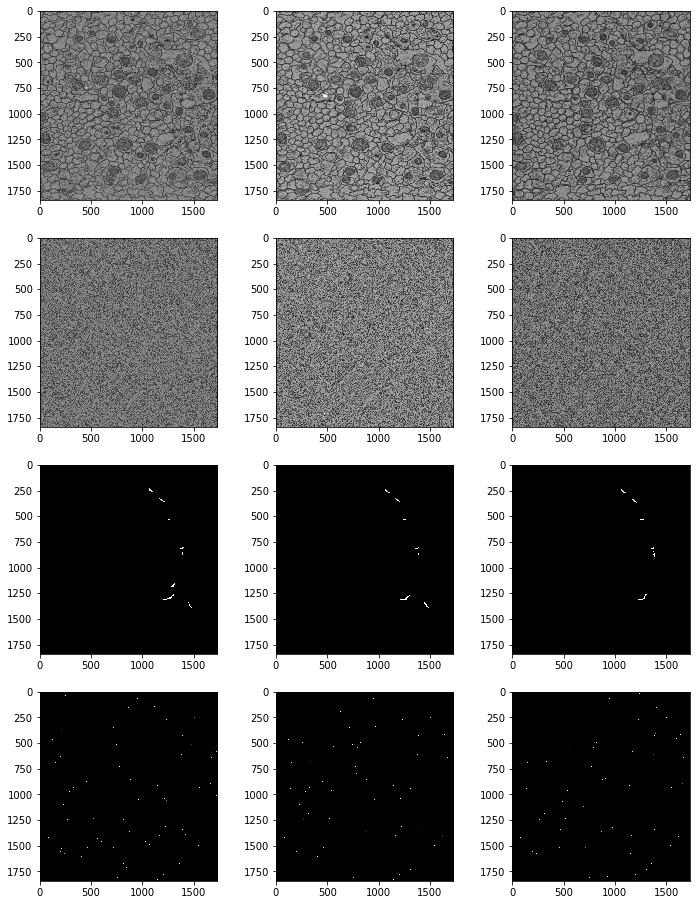

In [67]:
fig,ax=plt.subplots(4,3,figsize=(12,16))
for i in range(4):
    for j in range(3):
        if i ==0:
            ax[i,j].imshow(testdatraw[j],cmap='gray')
        elif i ==1:
            ax[i,j].imshow(F.shift_scale_rotate(testdatraw[j],45,0.05,0.05,0.05),cmap='gray')
        elif i ==2:
            ax[i,j].imshow(testdatseg[j],cmap='gray')
        elif i ==3:
            ax[i,j].imshow(F.shift_scale_rotate(testdatseg[j],45,0.05,0.05,0.05),cmap='gray')

##### center_crop
used to crop center

In [79]:
def center_crop(img, width,height):
    _, w, h= img.shape
    dy = (h-height)//2
    dx = (w-width)//2
    y1 = dy
    y2 = y1 + height
    x1 = dx
    x2 = x1 + width
    img = img[:, x1:x2, y1:y2]
    return img

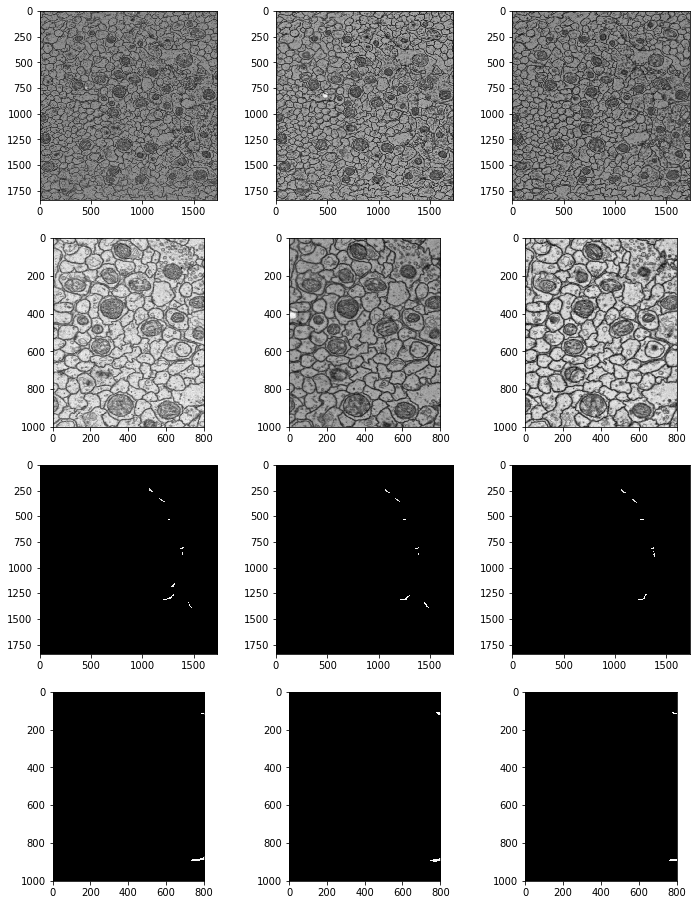

In [81]:
fig,ax=plt.subplots(4,3,figsize=(12,16))
for i in range(4):
    for j in range(3):
        if i ==0:
            ax[i,j].imshow(testdatraw[j],cmap='gray')
        elif i ==1:
            ax[i,j].imshow(center_crop(testdatraw, 1000,800)[j],cmap='gray')
        elif i ==2:
            ax[i,j].imshow(testdatseg[j],cmap='gray')
        elif i ==3:
            ax[i,j].imshow(center_crop(testdatseg, 1000,800)[j],cmap='gray')

In [82]:
def clip(img, dtype, maxval):
    return np.clip(img, 0, maxval).astype(dtype)

In [9]:
class Distort1(DualTransform):
    def __init__(self, distort_limit=0.05, shift_limit=0.05, prob=0.5):
        super().__init__(prob)
        self.shift_limit = shift_limit
        self.distort_limit = distort_limit
        self.shift_limit = shift_limit

    def apply(self, img, k=0, dx=0, dy=0):
        return F.distort1(img, k, dx, dy)

    def get_params(self):
        return {'k': random.uniform(-self.distort_limit, self.distort_limit),
                'dx': round(random.uniform(-self.shift_limit, self.shift_limit)),
                'dy': round(random.uniform(-self.shift_limit, self.shift_limit))}


class Distort2(DualTransform):
    def __init__(self, num_steps=5, distort_limit=0.3, prob=0.5):
        super().__init__(prob)
        self.num_steps = num_steps
        self.distort_limit = distort_limit
        self.prob = prob

    def apply(self, img, stepsx=[], stepsy=[]):
        return F.distort2(img, self.num_steps, stepsx, stepsy)

    def get_params(self):
        stepsx = [1 + random.uniform(-self.distort_limit, self.distort_limit) for i in range(self.num_steps + 1)]
        stepsy = [1 + random.uniform(-self.distort_limit, self.distort_limit) for i in range(self.num_steps + 1)]
        return {
            'stepsx': stepsx,
            'stepsy': stepsy
        }


class ElasticTransform(DualTransform):
    def __init__(self, alpha=1, sigma=50, alpha_affine=50, prob=0.5):
        super().__init__(prob)
        self.alpha = alpha
        self.alpha_affine = alpha_affine
        self.sigma = sigma

    def apply(self, img, random_state=None):
        return F.elastic_transform_fast(img, self.alpha, self.sigma, self.alpha_affine,
                                        np.random.RandomState(random_state))

    def get_params(self):
        return {'random_state': np.random.randint(0, 10000)}


class HueSaturationValue(ImageOnlyTransform):
    def __init__(self, hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, prob=0.5):
        # def __init__(self, hue_shift_limit=100, sat_shift_limit=50, val_shift_limit=10, prob=0.5, targets=('image')):
        super().__init__(prob)
        self.hue_shift_limit = hue_shift_limit
        self.sat_shift_limit = sat_shift_limit
        self.val_shift_limit = val_shift_limit

    def apply(self, image, hue_shift=0, sat_shift=0, val_shift=0):
        assert image.dtype == np.uint8 or self.hue_shift_limit < 1.
        return F.shift_hsv(image, hue_shift, sat_shift, val_shift)

    def get_params(self):
        return {'hue_shift': np.random.uniform(-self.hue_shift_limit, self.hue_shift_limit),
                'sat_shift': np.random.uniform(-self.sat_shift_limit, self.sat_shift_limit),
                'val_shift': np.random.uniform(-self.val_shift_limit, self.val_shift_limit)}


class RGBShift(ImageOnlyTransform):
    def __init__(self, r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, prob=0.5):
        super().__init__(prob)
        self.r_shift_limit = r_shift_limit
        self.g_shift_limit = g_shift_limit
        self.b_shift_limit = b_shift_limit

    def apply(self, image, r_shift=0, g_shift=0, b_shift=0):
        return F.shift_rgb(image, r_shift, g_shift, b_shift)

    def get_params(self):
        return {'r_shift': np.random.uniform(-self.r_shift_limit, self.r_shift_limit),
                'g_shift': np.random.uniform(-self.g_shift_limit, self.g_shift_limit),
                'b_shift': np.random.uniform(-self.b_shift_limit, self.b_shift_limit)}


class RandomBrightness(ImageOnlyTransform):
    def __init__(self, limit=0.2, prob=0.5):
        super().__init__(prob)
        self.limit = limit

    def apply(self, img, alpha=0.2):
        return F.random_brightness(img, alpha)

    def get_params(self):
        return {"alpha": 1.0 + self.limit * random.uniform(-1, 1)}


class RandomContrast(ImageOnlyTransform):
    def __init__(self, limit=.2, prob=.5):
        super().__init__(prob)
        self.limit = limit

    def apply(self, img, alpha=0.2):
        return F.random_contrast(img, alpha)

    def get_params(self):
        return {"alpha": 1.0 + self.limit * random.uniform(-1, 1)}


class Blur(ImageOnlyTransform):
    def __init__(self, blur_limit=7, prob=.5):
        super().__init__(prob)
        self.blur_limit = blur_limit

    def apply(self, image, ksize=3):
        return F.blur(image, ksize)

    def get_params(self):
        return {
            'ksize': np.random.choice(np.arange(3, self.blur_limit + 1, 2))
        }


class Remap(ImageOnlyTransform):
    backgrounds = {
        'gray': [216, 222, 222],
        'dark-gray': [206, 202, 202],
        'purple': [181, 159, 210],
        # 'pink': [211, 151, 204],
        'pink-gray': [235, 211, 235],
        # 'pink2': [208, 145, 202]
    }

    nuclei_max = {
        'gray': [80, 20, 105],
        'pink': [117, 12, 127],
        'purple': [82, 23, 192],
    }

    nuclei_center = {
        'gray': [149, 81, 168],
        'purple': [136, 107, 204],
        'pink': [170, 62, 176]
    }

    def apply(self, img, bg=[], center=[], max=[]):
        return F.remap_color(img, bg, center, max)

    def get_params(self):
        bg = random.choice(list(Remap.backgrounds.values()))
        center = random.choice(list(Remap.nuclei_center.values()))
        max = random.choice(list(Remap.nuclei_max.values()))
        return {
            'bg': bg,
            'center': center,
            'max': max
        }


class GaussNoise(ImageOnlyTransform):
    def apply(self, img, var=30):
        return F.gauss_noise(img, var=var)

    def get_params(self):
        return {
            'var': np.random.randint(10, 50)
        }


class MotionBlur(ImageOnlyTransform):
    def apply(self, img, **params):
        return F.motion_blur(img)


class MedianBlur(ImageOnlyTransform):
    def __init__(self, blur_limit=7, prob=.5):
        super().__init__(prob)
        self.blur_limit = blur_limit

    def apply(self, image, ksize=3):
        return F.median_blur(image, ksize)

    def get_params(self):
        return {
            'ksize': np.random.choice(np.arange(3, self.blur_limit + 1, 2))
        }


class CLAHE(ImageOnlyTransform):
    def __init__(self, clipLimit=4.0, tileGridSize=(8, 8), prob=0.5):
        super().__init__(prob)
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def apply(self, img, clipLimit=2):
        return F.clahe(img, clipLimit, self.tileGridSize)

    def get_params(self):
        return {"clipLimit": np.random.uniform(1, self.clipLimit)}


class IAAEmboss(ImageOnlyIAATransform):
    def __init__(self, alpha=(0.2, 0.5), strength=(0.2, 0.7), prob=0.5):
        super().__init__(prob)
        self.processor = iaa.Emboss(alpha, strength)


class IAASuperpixels(ImageOnlyIAATransform):
    '''
    may be slow
    '''

    def __init__(self, p_replace=0.1, n_segments=100, prob=0.5):
        super().__init__(prob)
        self.processor = iaa.Superpixels(p_replace=p_replace, n_segments=n_segments)


class IAASharpen(ImageOnlyIAATransform):
    def __init__(self, alpha=(0.2, 0.5), lightness=(0.5, 1.), prob=0.5):
        super().__init__(prob)
        self.processor = iaa.Sharpen(alpha, lightness)


class IAAAdditiveGaussianNoise(ImageOnlyIAATransform):
    def __init__(self, loc=0, scale=(0.01 * 255, 0.05 * 255), prob=0.5):
        super().__init__(prob)
        self.processor = iaa.AdditiveGaussianNoise(loc, scale)


class IAAPiecewiseAffine(DualIAATransform):
    def __init__(self, scale=(0.03, 0.05), nb_rows=4, nb_cols=4, prob=.5):
        super().__init__(prob)
        self.processor = iaa.PiecewiseAffine(scale, nb_rows, nb_cols)


class IAAPerspective(DualIAATransform):
    def __init__(self, scale=(0.05, 0.1), prob=.5):
        super().__init__(prob)
        self.processor = iaa.PerspectiveTransform(scale)


class ChannelShuffle(ImageOnlyTransform):
    def apply(self, img, **params):
        return F.channel_shuffle(img)


class InvertImg(ImageOnlyTransform):
    def apply(self, img, **params):
        return F.invert(img)


class ToThreeChannelGray(ImageOnlyTransform):
    def __init__(self, prob=1.):
        super().__init__(prob)

    def apply(self, img, **params):
        return F.to_three_channel_gray(img)


class ToGray(ImageOnlyTransform):
    def apply(self, img, **params):
        return F.to_gray(img)


class RandomLine(ImageOnlyTransform):
    def apply(self, img, **params):
        return F.random_polosa(img)


class AddChannel(ImageOnlyTransform):
    def __init__(self, prob=1.):
        super().__init__(prob)

    def apply(self, img, **params):
        return F.add_channel(img)


class FixMasks(BasicTransform):
    def __init__(self, prob=1.):
        super().__init__(prob)

    def apply(self, img, **params):
        return F.fix_mask(img)

    @property
    def targets(self):
        return ('mask',)


class ToTensor(BasicTransform):
    def __init__(self, num_classes=1):
        super().__init__(1.)
        self.num_classes = num_classes

    def __call__(self, **kwargs):
        kwargs.update({'image': F.img_to_tensor(kwargs['image'])})
        if 'mask' in kwargs.keys():
            kwargs.update({'mask': F.mask_to_tensor(kwargs['mask'], self.num_classes)})
        return kwargs

    @property
    def targets(self):
        raise NotImplementedError


def augment_flips_color(prob=.5):
    return Compose([
        CLAHE(),
        Remap(),
        RandomRotate90(),
        Transpose(),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, prob=.75),
        Blur(blur_limit=3),
        Distort1(),
        Distort2(),
        HueSaturationValue()
    ])


def aug_hardcore2(prob=.5):
    return Compose([
        Flip(prob=0.7),
        RandomRotate90(),
        Transpose(),
        ToGray(prob=0.2),
        RandomLine(prob=0.5),
        CLAHE(clipLimit=3),
        RandomBrightness(prob=0.2),
        RandomContrast(prob=0.2),
        GaussNoise(prob=0.2),
        # InvertImg(prob=0.3),
        Remap(0.3),
        Blur(blur_limit=3),
        # ElasticTransform(prob=0.2),
        Distort1(),
        Distort2(prob=0.3),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.40, rotate_limit=45, prob=.7),
        HueSaturationValue(),
        ChannelShuffle(prob=0.2),
        FixMasks(prob=1.),
        # AddChannel(prob=1.)
    ])


def aug_hardcore(prob=.5):
    return Compose([
        CLAHE(clipLimit=2, prob=0.35),
        GaussNoise(),
        ToGray(prob=0.25),
        InvertImg(prob=0.2),
        Remap(prob=0.4),
        RandomRotate90(),
        Flip(),
        Transpose(),
        Blur(blur_limit=3, prob=.4),
        RandomContrast(prob=.2),
        RandomBrightness(prob=.2),
        ElasticTransform(prob=0.3),
        Distort1(prob=0.3),
        Distort2(prob=.1),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.4, rotate_limit=45, prob=.7),
        HueSaturationValue(),
        ChannelShuffle(prob=.2),
        FixMasks(1.),
        # AddChannel(1.)
    ])


def aug_oneof(prob=.5):
    return Compose([
        Flip(prob=0.5),
        RandomRotate90(),
        Transpose(),
        ToGray(prob=0.2),
        RandomLine(prob=0.1),
        OneOf([
            CLAHE(clipLimit=3),
            RandomBrightness(prob=0.2),
            RandomContrast(prob=0.2),
            Blur(blur_limit=3),
        ]),
        GaussNoise(prob=0.2),
        OneOf([
            InvertImg(prob=0.3),
            Remap(0.3),
            HueSaturationValue(),
            # ChannelShuffle(prob=0.2)
        ]),
        # ElasticTransform(prob=0.2),
        OneOf([
            Distort1(),
            Distort2(prob=0.3),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.40, rotate_limit=45, prob=.7),
        ]),
        FixMasks(prob=1.),
        # AddChannel(prob=1.)
    ])


def aug_gray(prob=.5):
    return Compose([
        ToThreeChannelGray(),
        RGBShift(),
        RandomRotate90(),
        Transpose(),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.30, rotate_limit=45, prob=.6),
        Blur(blur_limit=7),
        Distort1(),
    ])


def aug_mega_hardcore(prob=.95):
    return Compose([
        OneOf([
            CLAHE(clipLimit=2, prob=.5),
            IAASharpen(prob=.25),
            IAAEmboss(prob=.25)
        ], prob=.35),
        OneOf([
            IAAAdditiveGaussianNoise(prob=.3),
            GaussNoise(prob=.7),
        ], prob=.5),
        ToGray(prob=.25),
        InvertImg(prob=.2),
        Remap(prob=.4),
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            MotionBlur(prob=.2),
            MedianBlur(blur_limit=3, prob=.3),
            Blur(blur_limit=3, prob=.5),
        ], prob=.4),
        OneOf([
            RandomContrast(prob=.5),
            RandomBrightness(prob=.5),
        ], prob=.4),
        ShiftScaleRotate(shift_limit=.0, scale_limit=.45, rotate_limit=45, prob=.7),
        OneOf([
            Distort1(prob=.2),
            Distort2(prob=.2),
            ElasticTransform(prob=.2),
            IAAPerspective(prob=.2),
            IAAPiecewiseAffine(prob=.2),
        ], prob=.6),
        HueSaturationValue(prob=.5),
        ChannelShuffle(prob=.2)
    ], prob=prob)

In [ ]:
def visualize_simple(options):
    if options =='x':
        boollist = [0,1,0,0]
    elif options =='y': 
        boollist = [0,0,1,0]
    elif options =='z': 
        boollist = [1,0,0,0]
    elif options =='trans':
        boollist = [0,0,0,1]
    fig,ax=plt.subplots(4,3,figsize=(18,24))
    for i in range(4):
        for j in range(3):
            if i ==0:
                ax[i,j].imshow(testdatraw[j],cmap='gray')
            elif i ==1:
                ax[i,j].imshow(augmentflip(testdatraw, boollist)[j],cmap='gray')
            elif i ==2:
                ax[i,j].imshow(testdatseg[j],cmap='gray')
            elif i ==3:
                ax[i,j].imshow(augmentflip(testdatseg, boollist)[j],cmap='gray')